In [28]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import itertools
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mpl_toolkits.basemap import Basemap

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/Users/RyanSampana/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/RyanSampana/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Preprocess

In [2]:
df = pd.read_csv('./data/final/completed_final_asian_carp.csv')

In [3]:
def make_cluster_df(df):
    length = []
    n_abs = []
    n_pres = []
    clusters = np.unique(df['cluster'])
    for cluster in clusters:
        ye = df[df['cluster'] == cluster]
        length.append(len(ye))
        n_abs.append(len(ye[ye['status']==0.0]))
        n_pres.append(len(ye[ye['status']==1.0]))

    out_df = pd.DataFrame([clusters,length,n_abs,n_pres])
    out_df = out_df.T
    out_df.columns = ['cluster','length','n_abs','n_pres']
    out_df = out_df.set_index(['cluster'])
    return out_df

list_of_features = ['May_Mean_Temp1', 'May_Mean_Precip1', 'Slope', 'Elevation', 
                    'FlowDir','FlowAcc_Flow1', 'StreamO_over1']

def special_kfold(df,test_clusters = 1,list_of_features=['May_Mean_Temp1', 'May_Mean_Precip1', 'Slope', 'Elevation', 
                    'FlowDir','FlowAcc_Flow1', 'StreamO_over1']):
    
    if type(test_clusters) == int:
        X_train = df[list_of_features][df['cluster'] != test_clusters]
        X_test = df[list_of_features][df['cluster'] == test_clusters]
       
        y_train = df['status'][df['cluster'] != test_clusters]
        y_test = df['status'][df['cluster'] == test_clusters]
    
    else:
        X_train_string = "df["
        X_test_string = "df["
        
        for a_cluster in test_clusters:
            X_train_string += "(df['cluster'] !="+str(a_cluster)+") &"
            X_test_string += "(df['cluster'] =="+str(a_cluster)+") |"
       
        X_train_string = X_train_string[:-1]
        X_train_string += "]"
        X_train = eval(X_train_string)
        y_train = X_train['status']
        X_train = X_train[list_of_features]
        
        X_test_string = X_test_string[:-1]
        X_test_string += "]"
        X_test = eval(X_test_string)
        y_test = X_test['status']
        X_test = X_test[list_of_features]
        
    #return X_train,y_train,X_test,y_test
    return np.array(X_train),np.array(y_train),np.array(X_test),np.array(y_test)
    
df_cluster = make_cluster_df(df)

In [4]:
big_clusters = df_cluster[(df_cluster['length']<=df_cluster.length.max()) &
                          (df_cluster['length']>=df_cluster.length.max()/3.0)].index

In [5]:
big_clusters

Int64Index([0, 18, 23, 37, 42, 66], dtype='int64', name=u'cluster')

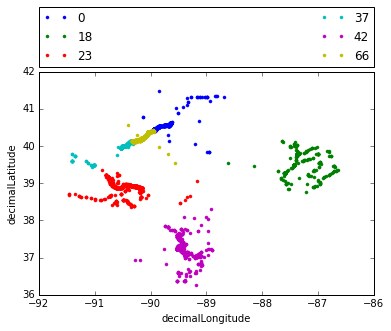

In [6]:
%matplotlib inline
plt.figure()
for cluster in big_clusters:
    x = df['decimalLongitude'][df['cluster']==cluster]
    y = df['decimalLatitude'][df['cluster']== cluster]
    plt.plot(x,y,label=str(cluster),marker='.',linewidth=0)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)    
plt.xlabel('decimalLongitude')
plt.ylabel('decimalLatitude')

# ML starts here

# First lets try Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from concurrent.futures import ThreadPoolExecutor
import itertools
from functools import partial


def parallel_classify(my_clf,list_of_features,test_clusters,df):
    X_train,y_train,X_test,y_test = special_kfold(df,
                                                  test_clusters = test_clusters,
                                                  list_of_features = list_of_features)
    my_clf.fit(X_train,y_train)
    y_pred = my_clf.predict(X_test)
    
    return (accuracy_score(y_true=y_test,y_pred=y_pred),
            confusion_matrix(y_true=y_test,y_pred=y_pred))

def testy(test_model = GaussianNB):
    feature_list = []
    acc = []
    list_of_features = ['May_Mean_Temp1', 'May_Mean_Precip1', 'Slope', 'Elevation', 
                    'FlowDir','FlowAcc_Flow1', 'StreamO_over1']
    best_clusters = [23,18]
    permutations_of_features = []
    
    for r in range(2,len(list_of_features)):
        for x in itertools.combinations(list_of_features,r=r):
            permutations_of_features.append(x)

    e = ThreadPoolExecutor(4)
    
    futures = [e.submit(parallel_classify,my_clf=test_model(),
                        list_of_features=list(permutation),
                        test_clusters=best_clusters,df=df) for permutation in permutations_of_features]
    
    results = [f.result() for f in futures]
    
    accs,cnf_matricies = zip(*results)
    
    nb_results = pd.DataFrame([permutations_of_features,list(accs),list(cnf_matricies)])
    nb_results = nb_results.T
    nb_results.columns = ['feature list','acc','confusion matrix']
    nb_results_max = nb_results[nb_results['acc'] == nb_results.acc.max()]
    
    return nb_results, nb_results_max

results_naive_bayes,best_naive_bayes = testy()

###  Best Result

In [15]:
best_naive_bayes

,feature list,acc,confusion matrix
48,"(Slope, Elevation, StreamO_over1)",0.899937,"[[110, 44], [115, 1320]]"


### Some Top Results

In [29]:
results_naive_bayes[(results_naive_bayes['acc'] < 1.0) & (results_naive_bayes['acc'] > 0.85)]

,feature list,acc,confusion matrix
14,"(Slope, StreamO_over1)",0.89742,"[[107, 47], [116, 1319]]"
29,"(May_Mean_Temp1, Slope, StreamO_over1)",0.89742,"[[107, 47], [116, 1319]]"
39,"(May_Mean_Precip1, Slope, StreamO_over1)",0.89742,"[[107, 47], [116, 1319]]"
48,"(Slope, Elevation, StreamO_over1)",0.899937,"[[110, 44], [115, 1320]]"
50,"(Slope, FlowDir, StreamO_over1)",0.894273,"[[109, 45], [123, 1312]]"
59,"(May_Mean_Temp1, May_Mean_Precip1, Slope, Stre...",0.89742,"[[107, 47], [116, 1319]]"
68,"(May_Mean_Temp1, Slope, Elevation, StreamO_over1)",0.899308,"[[109, 45], [115, 1320]]"
70,"(May_Mean_Temp1, Slope, FlowDir, StreamO_over1)",0.892385,"[[109, 45], [126, 1309]]"
78,"(May_Mean_Precip1, Slope, Elevation, StreamO_o...",0.899308,"[[109, 45], [115, 1320]]"
80,"(May_Mean_Precip1, Slope, FlowDir, StreamO_over1)",0.892385,"[[109, 45], [126, 1309]]"


In [16]:
# sums = []
# for x in range(0,100):
#     s,_ = parallel_classify(my_clf=GaussianNB(),
#                             list_of_features=list_of_features[1:5],
#                             test_clusters=x,
#                             df=df)
#     sums.append(s)
# print np.max(sums)
# print np.mean(sums)
# print np.std(sums)

# Now lets do an ensemble of 10 RandomForest Classifiers (default on sklearn)

In [21]:
from sklearn import ensemble
rnd_forest = ensemble.RandomForestClassifier
result_rnd_forest_default,max_rnd_forest_default = testy(test_model=rnd_forest)

### Best result

In [22]:
max_rnd_forest_default

,feature list,acc,confusion matrix
88,"(Slope, Elevation, FlowAcc_Flow1, StreamO_over1)",0.923851,"[[117, 37], [84, 1351]]"


### Some of the top results

In [23]:
result_rnd_forest_default[(result_rnd_forest_default['acc'] < 1.0) & (result_rnd_forest_default['acc'] > 0.9)]

,feature list,acc,confusion matrix
88,"(Slope, Elevation, FlowAcc_Flow1, StreamO_over1)",0.923851,"[[117, 37], [84, 1351]]"
90,"(Elevation, FlowDir, FlowAcc_Flow1, StreamO_ov...",0.905601,"[[124, 30], [120, 1315]]"
103,"(May_Mean_Temp1, Slope, Elevation, FlowAcc_Flo...",0.905601,"[[133, 21], [129, 1306]]"
108,"(May_Mean_Precip1, Slope, Elevation, FlowAcc_F...",0.900566,"[[131, 23], [135, 1300]]"
118,"(May_Mean_Precip1, Slope, Elevation, FlowDir, ...",0.909377,"[[131, 23], [121, 1314]]"


# Random tree with a some parameters tuned, 
### we use 13 esitmators, min_samples_split = 2 , min_samples_leaf=2

In [25]:
def parallel_classify_rnd(list_of_features,test_clusters,df):
    X_train,y_train,X_test,y_test = special_kfold(df,
                                                  test_clusters = test_clusters,
                                                  list_of_features = list_of_features)
    
    rnd_forest = ensemble.RandomForestClassifier(n_estimators=13,min_samples_split=2, min_samples_leaf=2,n_jobs=-1)
    my_clf = rnd_forest
    my_clf.fit(X_train,y_train)
    y_pred = my_clf.predict(X_test)
    
    return (accuracy_score(y_true=y_test,y_pred=y_pred),
            confusion_matrix(y_true=y_test,y_pred=y_pred))

feature_list = []
acc = []
list_of_features = ['May_Mean_Temp1', 'May_Mean_Precip1', 'Slope', 'Elevation', 
                'FlowDir','FlowAcc_Flow1', 'StreamO_over1']
best_clusters = [23,18]
permutations_of_features = []

for r in range(2,len(list_of_features)):
    for x in itertools.combinations(list_of_features,r=r):
        permutations_of_features.append(x)

results = [parallel_classify_rnd(list(permutation),best_clusters,df) for permutation in permutations_of_features]

accs,cnf_matricies = zip(*results)

nb_results = pd.DataFrame([permutations_of_features,list(accs),list(cnf_matricies)])
nb_results = nb_results.T
nb_results.columns = ['feature list','acc','confusion matrix']
nb_results_max = nb_results[nb_results['acc'] == nb_results.acc.max()]

### Best Result

In [26]:
nb_results_max

,feature list,acc,confusion matrix
48,"(Slope, Elevation, StreamO_over1)",0.930774,"[[106, 48], [62, 1373]]"


### Some of the Top Results

In [27]:
nb_results[(nb_results['acc'] < 1.0) & (nb_results['acc'] > 0.9)]

,feature list,acc,confusion matrix
17,"(Elevation, StreamO_over1)",0.91567,"[[130, 24], [110, 1325]]"
48,"(Slope, Elevation, StreamO_over1)",0.930774,"[[106, 48], [62, 1373]]"
67,"(May_Mean_Temp1, Slope, Elevation, FlowAcc_Flow1)",0.916929,"[[126, 28], [104, 1331]]"
77,"(May_Mean_Precip1, Slope, Elevation, FlowAcc_F...",0.90623,"[[127, 27], [122, 1313]]"
88,"(Slope, Elevation, FlowAcc_Flow1, StreamO_over1)",0.902454,"[[114, 40], [115, 1320]]"
90,"(Elevation, FlowDir, FlowAcc_Flow1, StreamO_ov...",0.904972,"[[127, 27], [124, 1311]]"
101,"(May_Mean_Temp1, Slope, Elevation, FlowDir, Fl...",0.901825,"[[124, 30], [126, 1309]]"
103,"(May_Mean_Temp1, Slope, Elevation, FlowAcc_Flo...",0.911265,"[[133, 21], [120, 1315]]"
108,"(May_Mean_Precip1, Slope, Elevation, FlowAcc_F...",0.915041,"[[123, 31], [104, 1331]]"
110,"(May_Mean_Precip1, Elevation, FlowDir, FlowAcc...",0.902454,"[[133, 21], [134, 1301]]"


# What about SVMs

In [ ]:
results_naive_bayes,best_SVC_default = testy(test_model= SVC)

Taking forever, I'm probably gonna sumbit as a job on server